# MNIST 手写数字

参考Kaggle的练习实现

目标：
1. 设计一个层数 $\geq 2$ 的神经网络（NN、MLP），处理识别 minist 手写数字图片。 $ \mathbb{R}^{n} \to \{0, 1, \ldots, 9\}$ 
2. 50k训练数据，图片大小 28x28 像素， 表示 0 ~ 9 的手写数字。 10k验证数据； 10k测试数据
3. 测试数据上accuracy至少95%，满分需要达到 98%以上。 画出 train loss和test loss曲线

## 0. import

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import keras


/home/yangdong/Applications/miniconda3/envs/DL3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. 数据预处理

In [4]:
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
y_train, y_val, y_test = map(keras.utils.np_utils.to_categorical, [y_train, y_val, y_test])

# X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(50000, 28, 28) (50000, 10)
(10000, 28, 28) (10000, 10)
(10000, 28, 28) (10000, 10)


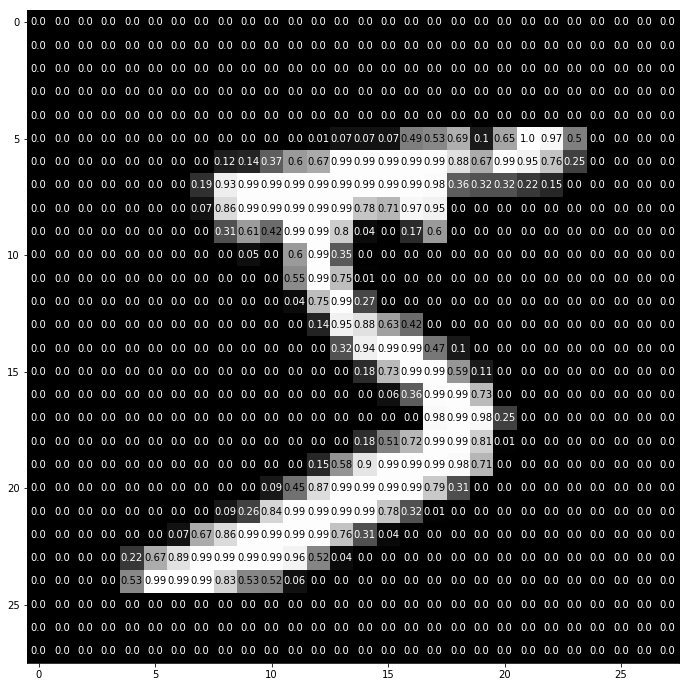

In [3]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
visualize_input(X_train[0], ax)

## 2. Keras Model - MLP

主要思想：

1. 2层MLP足以表现映射函数，不添加正则化手段，可以使训练集上的准确度到100%。但是测试集上的准确度，由于过拟合的原因，相对较低。
2. 两种策略可以提高测试集的准确度：
    1. 增加训练集（ Data augmentation）
    2. 正则化

主要使用Dropout正则化的方式


实验记录：

1. (512, tanh, dropout=0) (256, tanh, dropout=0) ，训练 （150， 128）,  准确率： (0.99+, 0.9797)。在训练集上过拟合，测试集误差提升不了了。

2. (512, relu, dropout=0) (256, relu, dropout=0)， 训练 （50， 128）， 准确率会非常差 0.09... 与初始化条件有关系？

3. (512, tanh, dropout=0.1) (256, tanh, dropout=0)， 加了dropout层， 准去了（0.98+， 0.97）。。 

4. 参考另外一个练习的结构，使用 `InputLayer([28, 28])` 而不是直接的 `InputLayer([784])` ，效果会好很多。一开始就很不错。


神经网络的一些参数、结构的调整，都是经验性质的，没有什么确切的内部含义。这一点是最不好的。

但另一方面，确实是有效果的。



In [5]:

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
y_train, y_val, y_test = map(keras.utils.np_utils.to_categorical, [y_train, y_val, y_test])

In [6]:
import keras
from keras.models import Sequential
import keras.layers as ll

model = Sequential(name="mlp")

model.add(ll.InputLayer([28, 28]))
model.add(ll.Flatten())
# model.add(ll.InputLayer([784]))
# network body
model.add(ll.Dense(500))
model.add(ll.Activation('relu'))

model.add(ll.Dense(300))
model.add(ll.Activation('relu'))

# output layer: 10 neurons for each class with softmax
model.add(ll.Dense(10, activation='softmax'))


In [7]:

from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='mnist.model.best.hdf5', verbose=1, save_best_only=True)

# categorical_crossentropy is your good old crossentropy
# but applied for one-hot-encoded vectors
model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])

In [8]:
score = model.evaluate(X_val, y_val, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('validation accuracy: %.4f%%' % accuracy)

validation accuracy: 15.3500%


In [9]:

# model.fit(X_train, y_train, 
#           epochs=100, batch_size=128, 
#           validation_data=(X_val, y_val), 
#           callbacks=[checkpointer], verbose=1)
model.fit(X_train, y_train,
          validation_data=(X_val, y_val), epochs=50);

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2011 - acc: 0.9393 - val_loss: 0.0957 - val_acc: 0.9708
Epoch 2/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.0855 - acc: 0.9734 - val_loss: 0.0817 - val_acc: 0.9745
Epoch 3/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.0565 - acc: 0.9820 - val_loss: 0.0868 - val_acc: 0.9755
Epoch 4/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.0441 - acc: 0.9858 - val_loss: 0.0849 - val_acc: 0.9766
Epoch 5/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.0358 - acc: 0.9884 - val_loss: 0.0786 - val_acc: 0.9797
Epoch 6/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.0286 - acc: 0.9907 - val_loss: 0.0988 - val_acc: 0.9769
Epoch 7/50
50000/50000 [==============================] - 3s 51us/step - loss: 0.0240 - acc: 0.9925 - val_loss: 0.1008 - val_acc

In [10]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 19us/step


[0.19390625303040535, 0.9808]

## 3. Tensorflow - MLP

实验记录：

### 1. 无正则化

```
n_hidden_1 = 512
n_hidden_2 = 256
learning_rate = 0.0003
epochs = 200
batch_size = 128
dropout_keep_prob = 1.0
```

调试了很久。发现 learning_rate 真是一个关键的参数。 开始都是设置为0.1，怎么都到不了90% 的正确率，有时候还非常低（不到10%）。 后来设置小一点，发现效果提升很明显。。

设置为0.001，无正则化效果：得到结果：
```
Epoch 150, Minibatch Loss = 0.0874, Training/Test Acc = 0.9985 / 0.9754
Epoch 160, Minibatch Loss = 0.0746, Training/Test Acc = 0.9989 / 0.9761
Epoch 170, Minibatch Loss = 0.0225, Training/Test Acc = 0.9995 / 0.9784
Epoch 180, Minibatch Loss = 0.0218, Training/Test Acc = 0.9997 / 0.9790
Epoch 190, Minibatch Loss = 0.0117, Training/Test Acc = 0.9996 / 0.9782
```
纯训练，理论上应该 100%训练集正确率。 然后想办法提升 测试集正确率


### 2. 正则化

```
n_hidden_1 = 512
n_hidden_2 = 256
learning_rate = 0.0001
epochs = 200
batch_size = 128
dropout_keep_prob = 0.7
```

实际上是第三轮。大概 600个 epoch之后，测试集上达到 98%的准确度。
```
Epoch 160, Minibatch Loss = 0.0013, Training/Test Acc = 0.9998 / 0.9802
Epoch 170, Minibatch Loss = 0.0012, Training/Test Acc = 0.9998 / 0.9805
Epoch 180, Minibatch Loss = 0.0011, Training/Test Acc = 0.9998 / 0.9804
Epoch 190, Minibatch Loss = 0.0011, Training/Test Acc = 0.9998 / 0.9794
```

但是感觉上 keep_prob并没有设么效果...`keep_prob=0.6` 训练 600个epoch：
```
Epoch 260, Minibatch Loss = 0.0160, Training/Test Acc = 0.9953 / 0.9752
Epoch 270, Minibatch Loss = 0.0156, Training/Test Acc = 0.9955 / 0.9760
Epoch 280, Minibatch Loss = 0.0152, Training/Test Acc = 0.9956 / 0.9753
Epoch 290, Minibatch Loss = 0.0151, Training/Test Acc = 0.9958 / 0.9762
```

### 3. L2 正则化

参考一个同学的作业。




### 出现的问题

#### 训练的准确度总是很差

1. 确认模型正确
2. 确认learning rate，如果过大，就不容易训练成功。

#### 训练集的准确率在提升， 测试集的准确率反而下降了。。。

1. relu会有这个问题，改成tanh之后问题消失。
2. leaky_relu也有这个问题，不知道具体原因是什么


#### sigmoid 效果不如 tanh

sigmoid
```
Epoch 0, Minibatch Loss = 1.1800, Training/Test Acc = 0.7605 / 0.7467
Epoch 1, Minibatch Loss = 0.7487, Training/Test Acc = 0.8271 / 0.8006
Epoch 20, Minibatch Loss = 0.2106, Training/Test Acc = 0.9368 / 0.7697
Epoch 40, Minibatch Loss = 0.1409, Training/Test Acc = 0.9563 / 0.7315
Epoch 60, Minibatch Loss = 0.1035, Training/Test Acc = 0.9679 / 0.7444
Epoch 80, Minibatch Loss = 0.0791, Training/Test Acc = 0.9756 / 0.7389
Epoch 100, Minibatch Loss = 0.0634, Training/Test Acc = 0.9804 / 0.7558
```
tanh
```
Epoch 0, Minibatch Loss = 0.7980, Training/Test Acc = 0.7371 / 0.7769
Epoch 1, Minibatch Loss = 0.5619, Training/Test Acc = 0.8201 / 0.8419
Epoch 20, Minibatch Loss = 0.2487, Training/Test Acc = 0.9265 / 0.9262
Epoch 40, Minibatch Loss = 0.1826, Training/Test Acc = 0.9449 / 0.9386
Epoch 60, Minibatch Loss = 0.1424, Training/Test Acc = 0.9574 / 0.9474
Epoch 80, Minibatch Loss = 0.1194, Training/Test Acc = 0.9630 / 0.9520
Epoch 100, Minibatch Loss = 0.1011, Training/Test Acc = 0.9691 / 0.9566
```

In [15]:
import tensorflow as tf
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)
y_train, y_val, y_test = map(keras.utils.np_utils.to_categorical, [y_train, y_val, y_test])

In [17]:
# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_hidden_1 = 512 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_classes = 10 # MNIST total classes (0-9 digits)


tf.reset_default_graph()
# input, placeholder
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

# parameters
W1 = tf.Variable(tf.random_normal((n_input, n_hidden_1), stddev=0.1))
b1 = tf.Variable(tf.random_normal((n_hidden_1,), stddev=0.1))
W2 = tf.Variable(tf.random_normal((n_hidden_1, n_hidden_2), stddev=0.1))
b2 = tf.Variable(tf.random_normal((n_hidden_2,), stddev=0.1))
W3 = tf.Variable(tf.random_normal((n_hidden_2, n_classes), stddev=0.1))
b3 = tf.Variable(tf.random_normal((n_classes,), stddev=0.1))

# multi layer perceptron
Z1 = tf.matmul(X, W1) + b1
A1 = tf.nn.dropout(tf.nn.tanh(Z1), keep_prob=keep_prob)
Z2 = tf.matmul(A1, W2) + b2
A2 = tf.nn.dropout(tf.nn.tanh(Z2), keep_prob=keep_prob)
Z3 = tf.matmul(A2, W3) + b3    
A3 = tf.nn.softmax(Z3)

In [28]:
# Parameters
learning_rate = 0.001

# Define loss and optimizer
cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z3, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_function)

# Evaluate model (with test logits, for dropout to be disabled)
correct_prediction = tf.equal(tf.argmax(Z3, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [31]:
# start TensorFlow session
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()

sess.run(init)

# training parameters
train_size = X_train.shape[0]
epochs = 300
batch_size = 100
dropout_keep_prob = 0.5
display_epoch = 20


# training 
train_loss = []
val_loss = []

In [32]:
%%time
# Start training
for epoch in range(epochs):
    perm = np.arange(train_size)
    np.random.shuffle(perm)
    for i in range(0, train_size, batch_size):
        randidx = perm[i:i+batch_size]
        batch_x = X_train[randidx, :]
        batch_y = y_train[randidx, :]
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={X: batch_x, Y: batch_y, keep_prob: 0.5})

    if epoch % display_epoch == 0 or epoch == 1:
        loss, acc = sess.run([cost_function, accuracy], feed_dict={X: X_train, Y: y_train, keep_prob: 1.})
        train_loss.append(loss)
        loss2, acc2 = sess.run([cost_function, accuracy], feed_dict={X: X_test, Y: y_test, keep_prob: 1.})
        val_loss.append(loss2)

        print("Epoch " + str(epoch) + ", Minibatch Loss = " + \
              "{:.4f}".format(loss) + ", Training/Test Acc = " + \
              "{:.4f}".format(acc) + " / " + "{:.4f}".format(acc2))

# print("Optimization Finished!")

# # Calculate accuracy for MNIST test images
# print("Testing Accuracy:", \
#     sess.run(accuracy, feed_dict={X: X_test, Y: y_test, keep_prob: 1.}))

Epoch 0, Minibatch Loss = 0.2423, Training/Test Acc = 0.9289 / 0.9312
Epoch 1, Minibatch Loss = 0.1779, Training/Test Acc = 0.9465 / 0.9464
Epoch 20, Minibatch Loss = 0.0300, Training/Test Acc = 0.9906 / 0.9775
Epoch 40, Minibatch Loss = 0.0136, Training/Test Acc = 0.9956 / 0.9788
Epoch 60, Minibatch Loss = 0.0067, Training/Test Acc = 0.9981 / 0.9795
Epoch 80, Minibatch Loss = 0.0044, Training/Test Acc = 0.9987 / 0.9807
Epoch 100, Minibatch Loss = 0.0022, Training/Test Acc = 0.9994 / 0.9802
Epoch 120, Minibatch Loss = 0.0018, Training/Test Acc = 0.9996 / 0.9817


In [39]:

# Calculate accuracy for MNIST test images
print("Testing Accuracy:", \
    sess.run(accuracy, feed_dict={X: X_test, Y: y_test, keep_prob: 1.}))

Testing Accuracy: 0.9815


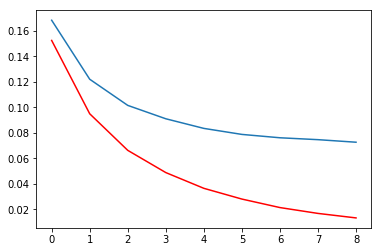

In [22]:
cut = 2
t = np.arange(len(train_loss)-cut)
plt.plot(t, train_loss[cut:], 'r-', t, val_loss[cut:], '-')
plt.show()

## 4. Tensorflow - MLP  update

参考更新

1. 使用 `get_variable`，并且使用 `xavier_initializer`。 对正态分布方差有一些调整
2. ~~每次从训练集中随机抽取 `batch size` 的数据进行训练。 这样做与先打乱训练集顺序，然后按`batch size`取数据进行训练，在计算时间上并没有太大差别。但是不知道为何，在训练效果上会比较好一些。 大概在90个epoch时，测试集准确率到达98%，但之前需要300个epoch。~~

没有在同样条件下比较： 上面的实验中， 每次训练集中随机抽取的方式，参数为 learning rate = 0.001, batch size = 100。 另一种先打乱，再抽取的方式， 参数为 learning rate = 0.0001, batch size = 128

当条件一致的时候（learning rate=0.001， batch size=100）， 先打乱后抽取，大概用了140个epoch稳定到达98%。 随机抽取方式用了 90~ 100 个epoch，稳定达到98%。


**进一步的想法：**

- 考虑添加l2 regularizer
- 考虑使用变化的learning rate。
- 考虑使用CNN。

In [23]:

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)
y_train, y_val, y_test = map(keras.utils.np_utils.to_categorical, [y_train, y_val, y_test])

In [24]:

# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_hidden_1 = 512 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_classes = 10 # MNIST total classes (0-9 digits)


tf.reset_default_graph()
# input, placeholder
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
keep_prob = tf.placeholder(tf.float32)

# parameters
W1 = tf.get_variable("W1", [n_input, n_hidden_1], initializer = tf.contrib.layers.xavier_initializer()) 
b1 = tf.get_variable("b1", [n_hidden_1], initializer = tf.zeros_initializer())
W2 = tf.get_variable("W2", [n_hidden_1, n_hidden_2], initializer = tf.contrib.layers.xavier_initializer())
b2 = tf.get_variable("b2", [n_hidden_2], initializer = tf.zeros_initializer())
W3 = tf.get_variable("W3", [n_hidden_2, n_classes], initializer = tf.contrib.layers.xavier_initializer())
b3 = tf.get_variable("b3", [n_classes], initializer = tf.zeros_initializer())

# multi layer perceptron
Z1 = tf.matmul(X, W1) + b1
A1 = tf.nn.dropout(tf.nn.tanh(Z1), keep_prob=keep_prob)
Z2 = tf.matmul(A1, W2) + b2
A2 = tf.nn.dropout(tf.nn.tanh(Z2), keep_prob=keep_prob)
Z3 = tf.matmul(A2, W3) + b3    
A3 = tf.nn.softmax(Z3)

In [37]:
# Parameters
learning_rate = 0.001
lambd = 0.001

# Define loss and optimizer
cost_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z3, labels=Y))

# regularizer = sum(map(tf.nn.l2_loss, [W1, b1, W2, b2, W3, b3]))
# cost_function = cost_function + lambd * regularizer

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost_function, var_list=[W1, b1, W2, b2, W3, b3])

# Evaluate model (with test logits, for dropout to be disabled)
correct_prediction = tf.equal(tf.argmax(Z3, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# start TensorFlow session
init = tf.global_variables_initializer()
sess = tf.InteractiveSession()

sess.run(init)

In [38]:
%%time
# training parameters
train_size = X_train.shape[0]
epochs = 300
batch_size = 100
dropout_keep_prob = 0.5

iter_per_epoch = int(train_size / batch_size)  # 50k / 100 = 500
iterations = int(iter_per_epoch * epochs)         # 100 epochs
display_epoch = int(iter_per_epoch * 10)        # display every 10 epoch


# training 
train_loss_list = []
test_loss_list = []

# Start training
for i in range(iterations):
    idx = np.random.choice(train_size, batch_size)
    batch_x = X_train[idx, :]
    batch_y = y_train[idx, :]
    sess.run(optimizer, feed_dict={X: batch_x, Y: batch_y, keep_prob: dropout_keep_prob})

    if (i+1) % display_epoch == 0:
        train_loss, train_acc = sess.run([cost_function, accuracy], 
                                         feed_dict={X: X_train, Y: y_train, keep_prob: 1.})
        train_loss_list.append(train_loss)
        test_loss, test_acc = sess.run([cost_function, accuracy], 
                                       feed_dict={X: X_test, Y: y_test, keep_prob: 1.})
        test_loss_list.append(test_loss)

        print("epoch " + str((i+1)/iter_per_epoch) + ", Training Loss = " + \
              "{:.4f}".format(train_loss) + ", Training/Test Acc = " + \
              "{:.4f}".format(train_acc) + " / " + "{:.4f}".format(test_acc))


epoch 10.0, Training Loss = 0.0658, Training/Test Acc = 0.9796 / 0.9697
epoch 20.0, Training Loss = 0.0352, Training/Test Acc = 0.9892 / 0.9764
epoch 30.0, Training Loss = 0.0209, Training/Test Acc = 0.9933 / 0.9794
epoch 40.0, Training Loss = 0.0167, Training/Test Acc = 0.9949 / 0.9807
epoch 50.0, Training Loss = 0.0105, Training/Test Acc = 0.9966 / 0.9802
epoch 60.0, Training Loss = 0.0086, Training/Test Acc = 0.9973 / 0.9810
epoch 70.0, Training Loss = 0.0055, Training/Test Acc = 0.9985 / 0.9826
epoch 80.0, Training Loss = 0.0046, Training/Test Acc = 0.9987 / 0.9810
epoch 90.0, Training Loss = 0.0039, Training/Test Acc = 0.9988 / 0.9824
epoch 100.0, Training Loss = 0.0033, Training/Test Acc = 0.9991 / 0.9807
epoch 110.0, Training Loss = 0.0025, Training/Test Acc = 0.9993 / 0.9819
epoch 120.0, Training Loss = 0.0027, Training/Test Acc = 0.9994 / 0.9812
epoch 130.0, Training Loss = 0.0015, Training/Test Acc = 0.9997 / 0.9828
epoch 140.0, Training Loss = 0.0018, Training/Test Acc = 0.9

In [27]:
# Calculate accuracy for MNIST test images
print("Testing Accuracy:", \
    sess.run(accuracy, feed_dict={X: X_test, Y: y_test, keep_prob: 1.}))

Testing Accuracy: 0.9817
